#                            Predict Health Outcomes of Horses


### imports

In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.impute import SimpleImputer , KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split , cross_validate , GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB , GaussianNB , BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , VotingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn import pipeline as impipline

### load the dataset

In [283]:
df = pd.read_csv("train.csv")
df

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,...,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,...,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,...,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived
1233,1233,yes,adult,534784,38.1,70.0,16.0,normal,reduced,bright_red,...,58.0,74.0,cloudy,2.0,yes,2209,0,0,no,lived


In [284]:
col_ = df.columns
col_

Index(['id', 'surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'surgical_lesion', 'lesion_1', 'lesion_2', 'lesion_3',
       'cp_data', 'outcome'],
      dtype='object')

### EDA

In [285]:
df.drop("id" ,axis = 1 , inplace= True)

In [286]:
df["temp_of_extremities"].unique()

array(['cool', 'cold', 'normal', 'warm', 'None'], dtype=object)

In [287]:
df.duplicated().sum()

0

In [288]:

for col in df:
    print(f'{col}: {df[col].unique()}')
    print(f'{df[col].value_counts()}')
    print(100*'*')

surgery: ['yes' 'no']
yes    887
no     348
Name: surgery, dtype: int64
****************************************************************************************************
age: ['adult' 'young']
adult    1160
young      75
Name: age, dtype: int64
****************************************************************************************************
hospital_number: [ 530001  533836  529812 5262541 5299629  529642  534787  529461  528742
  529640  528682  530028  528548  528134  528305  534885 5290482 5279822
  533692  535208  528523  529893  534145  530233  529399  530354  528503
  529796  527916  530360  528298  533871  529388  527563  534163  529827
  535196  535176  529045  527518  527463  529172  528996  533887  528904
  535407  533902  523190  534073  534135 5290409  529160  534917  534784
 5299253  534004  534115  529667 5297159  529427  527677  530612  535415
  530561  530242  530002 5289419  529498  529126 5291409 5287179  530526
 5290759  532110  534293  534280  528214  527933 5

There are data imbalances in some features.

The age Counts column contains a large number of adults.

slight in pain column , slight in nasogastric_reflux column, distend_small in peristalsis and serosanguious in rectal_exam_feces column have only one value.

None and none appeared in many feature, None is nan value but none is unique value in features.

The peripheral_pulse_Counts contains little number of absent and increased.

lesion_2 and lesion_3 have low variance or close to zero, then the features will not improve the performance of the model.

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1235 non-null   object 
 7   peripheral_pulse       1235 non-null   object 
 8   mucous_membrane        1235 non-null   object 
 9   capillary_refill_time  1235 non-null   object 
 10  pain                   1235 non-null   object 
 11  peristalsis            1235 non-null   object 
 12  abdominal_distention   1235 non-null   object 
 13  nasogastric_tube       1235 non-null   object 
 14  nasogastric_reflux     1235 non-null   object 
 15  naso

In [290]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hospital_number,1235.0,954500.401619,1.356403e+06,521399.0,528800.0,529777.0,534145.0,5305129.0
rectal_temp,1235.0,38.202186,7.886678e-01,35.4,37.8,38.2,38.6,40.8
pulse,1235.0,79.574089,2.910864e+01,30.0,53.0,76.0,100.0,184.0
respiratory_rate,1235.0,30.054251,1.645207e+01,8.0,18.0,28.0,36.0,96.0
nasogastric_reflux_ph,1235.0,4.382591,1.937357e+00,1.0,2.0,4.5,6.0,7.5
packed_cell_volume,1235.0,49.602429,1.053580e+01,23.0,43.0,48.0,57.0,75.0
total_protein,1235.0,21.388016,2.667645e+01,3.5,6.6,7.5,9.1,89.0
abdomo_protein,1235.0,3.290931,1.589195e+00,0.1,2.0,3.0,4.3,10.1
lesion_1,1235.0,3832.496356,5.436734e+03,0.0,2205.0,2209.0,3205.0,41110.0
lesion_2,1235.0,14.612146,1.937057e+02,0.0,0.0,0.0,0.0,3112.0


In [291]:
df.replace(to_replace='None', value=np.nan, inplace=True)

In [292]:
df.isna().sum()

surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
outcome                    0
dtype: int64

In [293]:
categorical_cols = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time',
                   'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces',
                   'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data']
num_cols = ['hospital_number','rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein',
           'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']


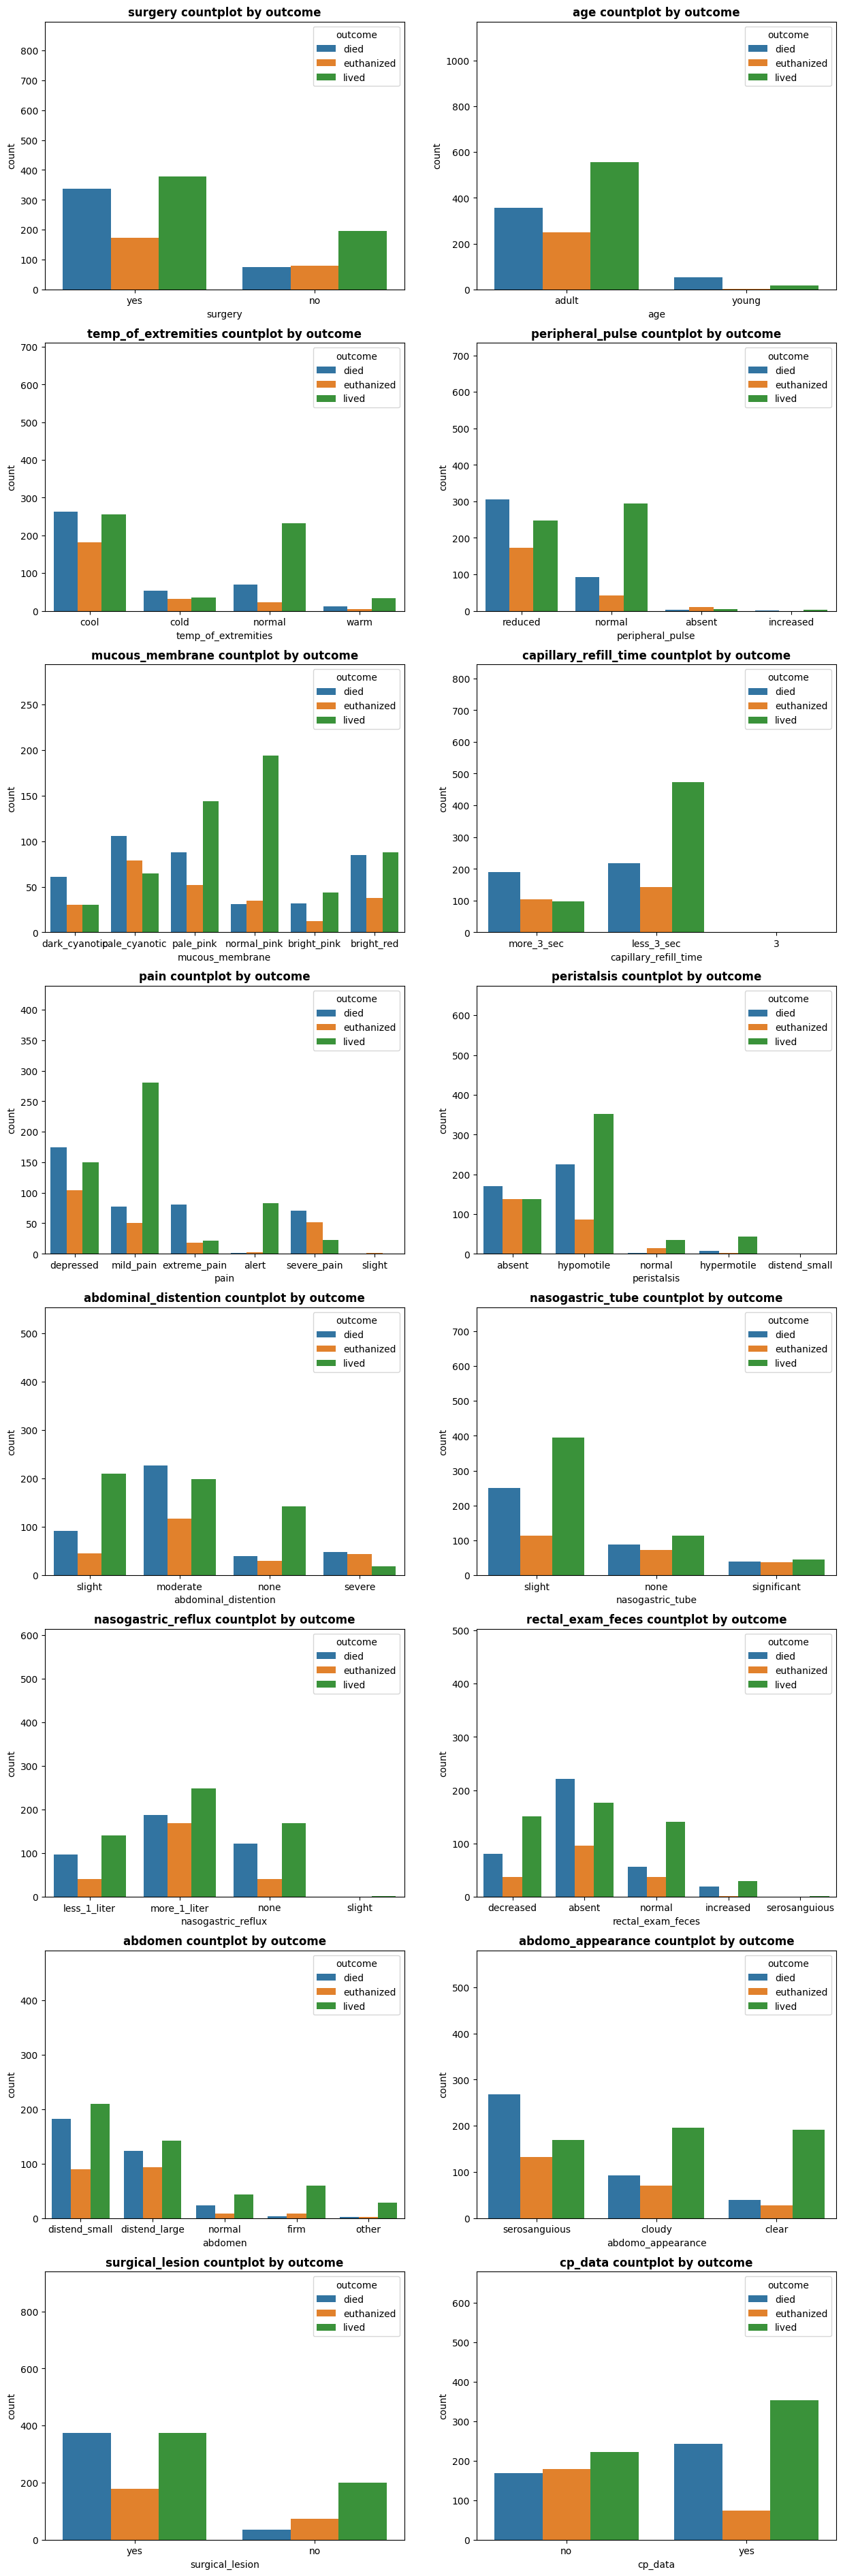

In [294]:
plt.figure(figsize=(15, len(categorical_cols)*3))

for i, col in enumerate(categorical_cols):
    
    plt.subplot(len(categorical_cols)//2 + len(categorical_cols) % 2, 2, i+1)
    sns.countplot(x=col, hue="outcome", data=df)
    plt.title(f"{col} countplot by outcome", fontweight = 'bold')
    plt.ylim(0, df[col].value_counts().max() + 10)
    
plt.show()

If the horse was treated with surgery it was a higher chance to die.

Young horses have more chance to die.

If Temp_Of_Extremities is warm or normal, the horse has a higher chance to live.

If Peripheral_Pulse is normal , the horse has a higher chance to live.

If Mucous_Membrane is pale_pink, bright_pink or normal_pink the horse has a higher chance to live.

If Capillary_Refill_Time is less_3_sec, the horse has a higher chance to live.

The mild_pain or alert in Pain give the horse a higher chance to survive.

The normal, hypermotile or hypomotile in Peristalsis give the horse a higher chance to survive.

The slight or none in Abdominal_Distention give the horse a higher chance to survive.

When Nasogastric_Tube is slight, there is higher chance that the horse is lived.

When Rectal_Exam_Feces is absent there is a higher chance that the horse is died.

When Abdomen is firm or other there is a higher chance that the horse is lived.

If the surgical_lesion is yes, then the horse has a higher chance to be died.



In [295]:
px.pie(data_frame=df ,names=df['outcome'] )

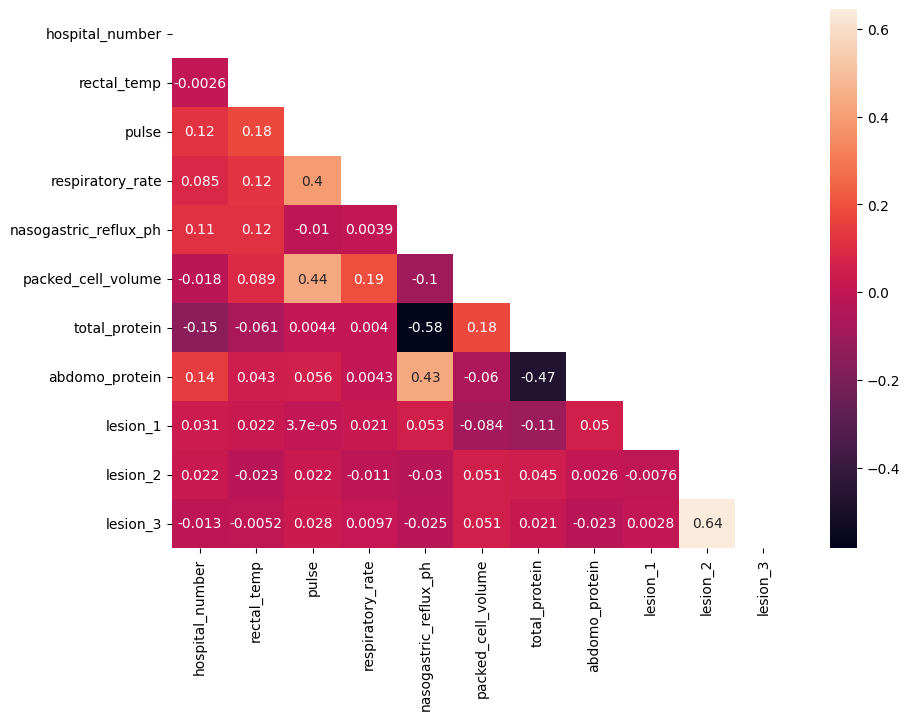

In [296]:
corr_matrix = df[num_cols].corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(10,7))
sns.heatmap(data=corr_matrix, mask=mask,annot=True)
plt.show()

In [297]:
df.drop(['lesion_2', 'lesion_3','hospital_number'] ,axis = 1 , inplace= True)

In [298]:
df

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,cp_data,outcome
0,yes,adult,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,...,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,no,died
1,yes,adult,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,...,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,no,euthanized
2,yes,adult,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,...,NaN,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,no,lived
3,yes,adult,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,...,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,yes,lived
4,no,adult,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,...,normal,normal,47.0,7.3,cloudy,2.6,no,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,yes,adult,38.5,129.0,48.0,cool,reduced,pale_pink,more_3_sec,depressed,...,NaN,distend_large,57.0,66.0,serosanguious,2.0,yes,2206,no,lived
1231,yes,adult,37.5,60.0,50.0,cool,reduced,pale_cyanotic,less_3_sec,mild_pain,...,decreased,distend_small,35.0,6.4,serosanguious,3.6,yes,2209,yes,died
1232,yes,young,37.5,84.0,40.0,normal,reduced,normal_pink,less_3_sec,mild_pain,...,increased,firm,40.0,5.9,cloudy,7.0,yes,400,yes,lived
1233,yes,adult,38.1,70.0,16.0,normal,reduced,bright_red,less_3_sec,mild_pain,...,absent,distend_small,58.0,74.0,cloudy,2.0,yes,2209,no,lived


### Preprocessing and modeling

In [299]:
#Drop the values that appeared one time in features
index = df[ (df['capillary_refill_time'] == '3') |(df['peripheral_pulse'] == 'increased') |(df['pain'] == 'slight') | (df['nasogastric_reflux'] == 'slight') | (df['peristalsis'] == 'distend_small') | (df['rectal_exam_feces'] == 'serosanguious')].index
df.drop(index , inplace=True)

In [300]:
df['outcome'] = df['outcome'].map({'died':0, 'euthanized':1,'lived':2})

In [301]:
df

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,cp_data,outcome
0,yes,adult,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,...,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,no,0
1,yes,adult,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,...,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,no,1
2,yes,adult,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,...,NaN,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,no,2
3,yes,adult,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,...,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,yes,2
4,no,adult,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,...,normal,normal,47.0,7.3,cloudy,2.6,no,0,yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,yes,adult,38.5,129.0,48.0,cool,reduced,pale_pink,more_3_sec,depressed,...,NaN,distend_large,57.0,66.0,serosanguious,2.0,yes,2206,no,2
1231,yes,adult,37.5,60.0,50.0,cool,reduced,pale_cyanotic,less_3_sec,mild_pain,...,decreased,distend_small,35.0,6.4,serosanguious,3.6,yes,2209,yes,0
1232,yes,young,37.5,84.0,40.0,normal,reduced,normal_pink,less_3_sec,mild_pain,...,increased,firm,40.0,5.9,cloudy,7.0,yes,400,yes,2
1233,yes,adult,38.1,70.0,16.0,normal,reduced,bright_red,less_3_sec,mild_pain,...,absent,distend_small,58.0,74.0,cloudy,2.0,yes,2209,no,2


In [302]:
x = df.drop("outcome" , axis =1 )
y = df['outcome']

In [303]:
Categorical_df = x.select_dtypes(include = "object")

In [304]:
numerical_df = x.select_dtypes(include = "number")

In [305]:
numerical_steps = []
numerical_steps.append(("Scaler" , RobustScaler()))

In [306]:
numerical_pipeline = Pipeline(steps= numerical_steps)

In [307]:
Categoricalsteps = []
Categoricalsteps.append(("CatImp" , SimpleImputer(strategy="most_frequent")))
Categoricalsteps.append(("Encoder" , OneHotEncoder(sparse_output=False , drop = "first")))

In [308]:
Categorical_pipeline = Pipeline(steps=Categoricalsteps)

In [309]:
Preprocessing = ColumnTransformer(transformers=[("numerical" , numerical_pipeline , numerical_df.columns),("Categorical" ,Categorical_pipeline , Categorical_df.columns )])

In [310]:
model = list()
model.append(("LR" , LogisticRegression(max_iter=1000)))
model.append(("GNB" , GaussianNB()))
model.append(("SVM" , SVC()))
model.append(("DT" , DecisionTreeClassifier()))
model.append(("KNN" , KNeighborsClassifier()))
model.append(("RF" , RandomForestClassifier()))
model.append(("XGB" , XGBClassifier()))
model.append(("voting" , VotingClassifier(estimators=[('KNN' , KNeighborsClassifier()) ,('SVM' , SVC()) ,('DT' , DecisionTreeClassifier()) , ("RF" , RandomForestClassifier()) , ("LR" , LogisticRegression(max_iter=1000))])))

In [311]:
for models in model:
    steps =[]
    steps.append(("Pre" , Preprocessing))
    steps.append(models)
    Final_Pipeline = Pipeline(steps=steps)
    scores = cross_validate(Final_Pipeline , x , y , cv = 7 , scoring="accuracy" , return_train_score=True)
    print(models[0])
    print("Train_accuracy" , scores["train_score"].mean() )
    print("-" * 10)
    print("Test_accuracy" , scores["test_score"].mean())
    print("-" * 20)
    print("\n")

LR
Train_accuracy 0.7247619047619048
----------
Test_accuracy 0.6824489795918367
--------------------


GNB
Train_accuracy 0.6511564625850339
----------
Test_accuracy 0.64
--------------------


SVM
Train_accuracy 0.6944217687074831
----------
Test_accuracy 0.6685714285714285
--------------------


DT
Train_accuracy 1.0
----------
Test_accuracy 0.5902040816326531
--------------------


KNN
Train_accuracy 0.7495238095238095
----------
Test_accuracy 0.64
--------------------


RF
Train_accuracy 1.0
----------
Test_accuracy 0.7069387755102042
--------------------


XGB
Train_accuracy 1.0
----------
Test_accuracy 0.7028571428571428
--------------------


voting
Train_accuracy 0.8738775510204082
----------
Test_accuracy 0.6963265306122449
--------------------




### hyperparameter tuning for XGBClassifier algorithm

In [312]:
#numerical_steps = []
#numerical_steps.append(("Scaler" , RobustScaler()))

In [313]:
#numerical_pipeline = Pipeline(steps= numerical_steps)

In [314]:
#Categoricalsteps = []
#Categoricalsteps.append(("CatImp" , SimpleImputer(strategy="most_frequent")))
#Categoricalsteps.append(("Encoder" , OneHotEncoder(sparse_output=False , drop = "first")))

In [315]:
#Categorical_pipeline = Pipeline(steps=Categoricalsteps)

In [316]:
#Preprocessing = ColumnTransformer(transformers=[("numerical" , numerical_pipeline , numerical_df.columns),("Categorical" ,Categorical_pipeline , Categorical_df.columns )])

In [317]:
#steps =[]
#steps.append(("Pre" , Preprocessing))
#steps.append(("XGB" , XGBClassifier()))
#Final_Pipeline = Pipeline(steps=steps)
    

In [318]:
#Final_Pipeline

In [319]:
#params = {
    #'XGB__n_estimators': [ 250 ,300,350],
    #"XGB__learning_rate": [0.01,0.03,0.05 ] ,
    #"XGB__max_depth": [ 2,3]
    
    
#}

In [320]:
#grid = GridSearchCV(estimator = Final_Pipeline , param_grid = params , cv = 5  ,return_train_score=True ,  scoring = "accuracy" )

In [321]:
#grid.fit(x,y)

In [322]:
#grid.best_params_

In [323]:
#grid.cv_results_["mean_test_score"].max()

In [324]:
#grid.cv_results_["mean_train_score"].max()

### hyperparameter tuning for RandomForestClassifier algorithm

In [325]:
#numerical_steps = []
#numerical_steps.append(("Scaler" , RobustScaler()))

In [326]:
#numerical_pipeline = Pipeline(steps= numerical_steps)

In [327]:
#Categoricalsteps = []
#Categoricalsteps.append(("CatImp" , SimpleImputer(strategy="most_frequent")))
#Categoricalsteps.append(("Encoder" , OneHotEncoder(sparse_output=False , drop = "first")))

In [328]:
#Categorical_pipeline = Pipeline(steps=Categoricalsteps)

In [329]:
#Preprocessing = ColumnTransformer(transformers=[("numerical" , numerical_pipeline , numerical_df.columns),("Categorical" ,Categorical_pipeline , Categorical_df.columns )])

In [330]:
#steps =[]
#steps.append(("Pre" , Preprocessing))
#steps.append(("RF" , RandomForestClassifier()))
#Final_Pipeline = Pipeline(steps=steps)
    

In [331]:
#params = {
    #'RF__n_estimators': [100, 200, 300],
    #'RF__criterion': ['gini', 'entropy'],
    #'RF__max_depth' :range(5,10)
#}

In [332]:
#grid = GridSearchCV(estimator = Final_Pipeline , param_grid = params , cv = 5  ,return_train_score=True ,  scoring = "accuracy" )

In [333]:
#grid.fit(x,y)

In [334]:
#grid.best_params_

In [335]:
#grid.cv_results_["mean_test_score"].max()

In [336]:
#grid.cv_results_["mean_train_score"].max()

# MODELING WITH XGBClassifier 

In [338]:
numerical_steps = []
numerical_steps.append(("Scaler" , RobustScaler()))

In [339]:
numerical_pipeline = Pipeline(steps= numerical_steps)

In [340]:
Categoricalsteps = []
Categoricalsteps.append(("CatImp" , SimpleImputer(strategy="most_frequent")))
Categoricalsteps.append(("Encoder" , OneHotEncoder(sparse_output=False , drop = "first")))

In [341]:
Categorical_pipeline = Pipeline(steps=Categoricalsteps)

In [342]:
steps =[]
steps.append(("Pre" , Preprocessing))
steps.append(("XGB" , XGBClassifier(learning_rate= 0.03, max_depth= 3, n_estimators= 300)))
Final_Pipeline = Pipeline(steps=steps)
    

In [346]:
Final_Pipeline.fit(x,y)

Pipeline(steps=[('Pre',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('Scaler',
                                                                   RobustScaler())]),
                                                  Index(['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph',
       'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('CatImp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  (...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.03,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=300,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

### Deployment with stremlit

In [347]:
import joblib

In [348]:
joblib.dump(Final_Pipeline,"Model.pkl")

['Model.pkl']

In [349]:
joblib.dump(x.columns , "inputs.pkl")

['inputs.pkl']

In [350]:
x.columns

Index(['surgery', 'age', 'rectal_temp', 'pulse', 'respiratory_rate',
       'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
       'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention',
       'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph',
       'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein',
       'abdomo_appearance', 'abdomo_protein', 'surgical_lesion', 'lesion_1',
       'cp_data'],
      dtype='object')

In [351]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

model = joblib.load("Model.pkl")
inputs = joblib.load("inputs.pkl")
def prediction(surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume, total_protein,abdomo_appearance, abdomo_protein, surgical_lesion, lesion_1,cp_data):
    df = pd.DataFrame(columns=inputs)
    df.at[0,'surgery'] =surgery
    df.at[0,'age'] =age
    df.at[0,'rectal_temp'] =rectal_temp
    df.at[0,'pulse'] =pulse
    df.at[0,'respiratory_rate'] =respiratory_rate
    df.at[0,'temp_of_extremities'] =temp_of_extremities
    df.at[0,'peripheral_pulse'] =peripheral_pulse
    df.at[0,'mucous_membrane'] =mucous_membrane
    df.at[0,'capillary_refill_time'] =capillary_refill_time
    df.at[0,'pain'] =pain
    df.at[0,'peristalsis'] =peristalsis
    df.at[0,'abdominal_distention'] =abdominal_distention
    df.at[0,'nasogastric_tube'] =nasogastric_tube
    df.at[0,'nasogastric_reflux'] =nasogastric_reflux
    df.at[0,'nasogastric_reflux_ph'] =nasogastric_reflux_ph
    df.at[0,'rectal_exam_feces'] =rectal_exam_feces
    df.at[0,'abdomen'] =abdomen
    df.at[0,'packed_cell_volume'] =packed_cell_volume
    df.at[0,'total_protein'] =total_protein
    df.at[0,'abdomo_appearance'] =abdomo_appearance
    df.at[0,'abdomo_protein'] =abdomo_protein
    df.at[0,'surgical_lesion'] =surgical_lesion
    df.at[0,'lesion_1'] =lesion_1
    df.at[0,'cp_data'] =cp_data
    res = model.predict(df)
    return res[0]


def main() :
    st.title("Health check of Horses")
    age= st.selectbox("Age" , ['adult' ,'young'])
    surgery = st.selectbox("Surgery ?" , ['yes', 'no'] )
    rectal_temp = st.slider("Rectal temperature" , min_value=35.0,max_value=41.0,step = 0.1 , value = 38.0)
    pulse = st.slider("Pulse" , min_value=30,max_value=185,step = 1 , value = 75)
    respiratory_rate = st.slider("Respiratory rate" ,min_value=7,max_value=97,step = 1 , value = 36)
    temp_of_extremities = st.selectbox("Temperature of extremities", ['cool' ,'cold' ,'normal', 'warm' ])
    peripheral_pulse = st.selectbox("Peripheral pulse",['reduced', 'normal', 'None','absent'])
    mucous_membrane = st.selectbox("Mucous membrane", ['dark_cyanotic','pale_cyanotic','pale_pink','normal_pink','bright_pink','bright_red'])
    capillary_refill_time = st.selectbox("Capillary refill time",['more_3_sec','less_3_sec'])
    pain = st.selectbox("Pain",['depressed','mild_pain','extreme_pain','alert','severe_pain'] )
    peristalsis= st.selectbox("Peristalsis",['absent','hypomotile','normal','hypermotile'])
    abdominal_distention = st.selectbox("Abdominal distention",['slight','moderate','none','severe'])
    nasogastric_tube = st.selectbox("Nasogastric tube",['slight','none','significant'])
    nasogastric_reflux = st.selectbox("Nasogastric reflux",['less_1_liter','more_1_liter','none'])
    nasogastric_reflux_ph = st.slider("Nasogastric reflux PH",min_value=0.0,max_value=8.0,step = 0.1 , value = 4.0)
    rectal_exam_feces = st.selectbox("Rectal examination feces",['decreased','absent','normal','increased' ])
    abdomen= st.selectbox("Abdomen",['distend_small','distend_large','normal','firm','other'])
    packed_cell_volume= st.slider("Packed cell volume",min_value=22,max_value=76,step = 1 , value = 57)
    total_protein = st.slider("total protein",min_value=3.0,max_value=90.0,step = 0.1 , value = 7.5)
    abdomo_appearance=st.selectbox("Abdominocentesis appearance",['serosanguious','cloudy','clear'])
    abdomo_protein=st.slider("Abdomcentesis total protein",min_value=0.0,max_value=10.0,step = 0.1 , value = 2.0)
    surgical_lesion = st.selectbox("surgical lesion ?" , ['yes' ,'no'])
    lesion_1 = st.selectbox("Type of lesion", [ 2209,2208,5124,0,3111,2207,3209,3205,2124,2206,31110,2205,7111,3207,4206,2113,3113,2112,4205,8300,1400,5400,7209,3115,11124,4207,9400,300,2111,3300,3112,400,2300,2322,3133,4300,3025,8400,1111,5206,11300,4124,12208,6112,7400,5000,5205,2202,3124,5111,6209,11400,6111,2305,21110,1124,41110])
    cp_data =st.selectbox("is pathology data present for this case ?", ['yes' ,'no'])
    if st.button("Predict"):
        result = prediction(surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume, total_protein,abdomo_appearance, abdomo_protein, surgical_lesion, lesion_1,cp_data)
        res_list = ['died','euthanized','lived']
        st.text(res_list[result])
main()

Overwriting app.py
